# Exploring the simulation results

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import scipy
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from tqdm import tqdm
from fitter import Fitter

from infant_abm.db_utils import load_run

params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (7, 4),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

## Helper

In [2]:
def running_avg(x, steps, m="same"):
    return np.convolve(x, np.ones(steps) / steps, mode=m)

In [3]:
def load_description(model, run_name):
    description_df, load_partial = load_run(f"results/{model}/{run_name}")
    result = load_partial(0)

    iterations = result["0"]["iterations"]
    repeats = len(result)
    n_samples = len(description_df)

    return n_samples, iterations, repeats, load_partial


def get_q_results(index):
    results = load_partial(index).values()

    rewards = np.array([r["rewards"] for r in results])
    rewards = np.average(rewards, axis=0)

    q_tables = [r["q_table"] for r in results]

    return rewards, q_tables


def load_v2run_results(model, run_name):
    description_df, _load_partial = load_run(f"results/{model}/{run_name}")

    results_df = description_df

    the_list = [get_q_results(index) for index in tqdm(results_df.index)]
    rewards, q_tables = zip(*the_list)

    results_df["rewards"] = rewards
    results_df["q_table"] = q_tables

    return results_df

In [4]:
MODEL = "v0.2.0"
RUN_NAME = "test_learn_10k"

N_SAMPLES, ITERATIONS, REPEATS, load_partial = load_description(MODEL, RUN_NAME)
results_df = load_v2run_results(MODEL, RUN_NAME)

100%|██████████| 45/45 [00:00<00:00, 1449.45it/s]


In [5]:
results_df

,perception,persistence,coordination,persistence_boost_value,coordination_boost_value,infant_kwargs,rewards,q_table
0,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.5, 'epsilon': 0.01}","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[[[0.3241246565933969, 0.7480789689178479, 0.1..."
1,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.5, 'epsilon': 0.05}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.3021875922134582, 0.706303740857758, 0.21..."
2,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.5, 'epsilon': 0.1}","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[[0.41747309275691225, 0.7633159340259297, 0...."
3,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.7, 'epsilon': 0.01}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.18003751820957226, 0.7788654319013921, 0...."
4,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.7, 'epsilon': 0.05}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.7125959790336742, 0.953130282980446, 0.30..."
5,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.7, 'epsilon': 0.1}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.5402425768874535, 0.8844472254039007, 0.2..."
6,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.8, 'epsilon': 0.01}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.5498862328974106, 1.6717194509928874, 0.4..."
7,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.8, 'epsilon': 0.05}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.8839898355249849, 1.5816433644152843, 0.2..."
8,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.8, 'epsilon': 0.1}","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[1.171364795891921, 1.7256732494071922, 0.34..."
9,0.35,0.35,0.35,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.9, 'epsilon': 0.01}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.9667664404350023, 3.6514878267585686, 0.4..."


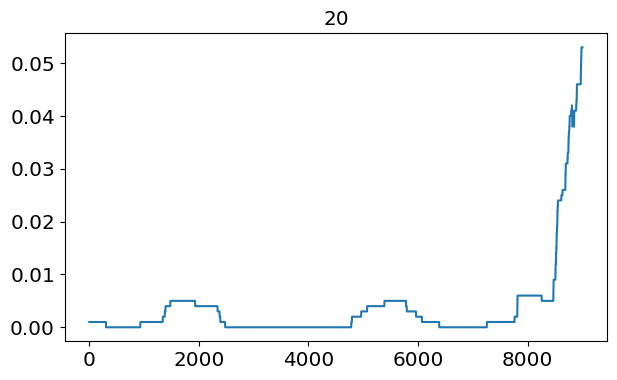

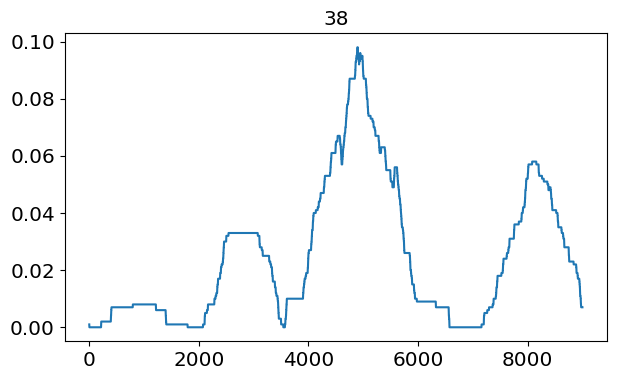

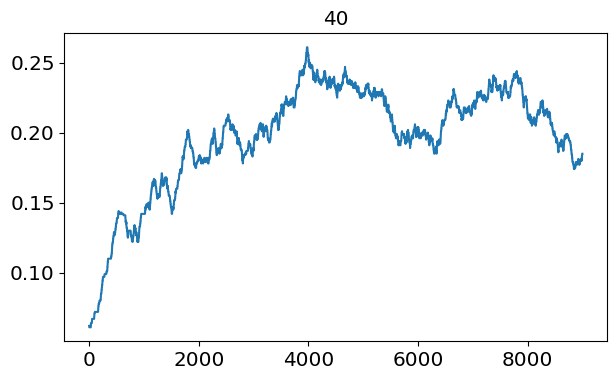

In [7]:
for i, row in results_df.sample(3).iterrows():
    avg = running_avg(row["rewards"], 1000, "valid")
    plot = sns.lineplot(avg)
    plot.set_title(f"{i}")
    plt.show()

In [28]:
q_states = np.array(range(8))
master_q_table = np.zeros(shape=results_df.iloc[0]["q_table"][0].shape)

for _i, row in results_df.iterrows():
    for q_table in row["q_table"]:
        argmax = np.argmax(q_table, axis=1)
        master_q_table[q_states, argmax] += 1

master_q_table

array([[ 0., 43.,  1.,  1.,  0.,  0.],
       [14., 27.,  1.,  2.,  1.,  0.],
       [ 6.,  5., 10.,  7.,  9.,  8.],
       [ 5.,  6.,  8.,  7., 13.,  6.],
       [ 8., 31.,  1.,  1.,  3.,  1.],
       [15., 12.,  7.,  3.,  7.,  1.],
       [ 9., 34.,  0.,  1.,  1.,  0.],
       [12., 16.,  2.,  7.,  4.,  4.]])

In [36]:
np.log(24)

3.1780538303479458

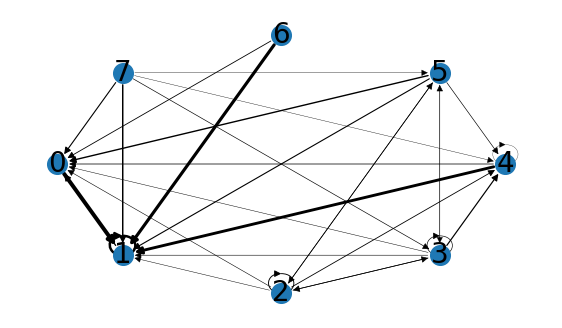

In [60]:
G = nx.DiGraph()

for i, row in enumerate(master_q_table):
    row_sum = np.sum(row)
    for j, w in enumerate(row):
        if w > 2:
            G.add_edge(i, j, weight=w / row_sum * 3)

pos = nx.shell_layout(
    G,
    # scale=20,
)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# edges
for u, v, d in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d["weight"])

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

plt.axis("off")
plt.show()

In [ ]:
np.argmax(self.q_table[state])}

In [8]:
results_df.iloc[0]["q_table"]

[array([[0.32412466, 0.74807897, 0.1296658 , 0.02484495, 0.23205376,
         0.27053278],
        [0.44376698, 0.68978109, 0.44563121, 0.19016649, 0.37039742,
         0.04849951],
        [0.31077957, 0.41458521, 0.59217522, 0.54470293, 0.28421018,
         0.38440528],
        [0.36139888, 0.17357028, 0.68077539, 0.85128872, 0.32015588,
         0.6320495 ],
        [0.0410409 , 0.05985481, 0.04104193, 0.04113962, 0.04086533,
         0.04138622],
        [0.09757991, 0.12048751, 0.12419589, 0.12357632, 0.12113125,
         0.12386307],
        [0.01532979, 0.07960239, 0.0174944 , 0.01514701, 0.01491346,
         0.01597   ],
        [0.06178989, 0.03374355, 0.0335758 , 0.00250463, 0.03327602,
         0.03364816]])]

In [12]:
myarr = np.ones(shape=(2, 2))
myarr.tofile("dupa")

newarr = np.fromfile("dupa", dtype="float")
print(newarr)

[1. 1. 1. 1.]
